<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D1%82%D1%80%D0%B8_%D1%81%D0%BB%D0%BE%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA
! pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-e71r4d0o
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-e71r4d0o
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=08bba1a495d99ed90d4000e7e66175cc727787b346f5b29661a45a8fae02e512
  Stored in directory: /tmp/pip-ephem-wheel-cache-ccoq4q7g/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-82usgbaw
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-82usgbaw
  Created wheel for progOrder: filename=progOrder-0.0.3-cp36-none-any.whl size=2381 sha256=4034c45bc724380d19bee39927c6ac78880ddaa7ad7b82b092892a76c3796345
  Stored in directory: /tmp/pip-ephem-wheel-cache-agv5eahf/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [ ]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
from progOrder import getBuySellForData
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Загрузка данных

In [ ]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2008, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562
2008-01-10,102.07,103.81,101.53,103.53,39745084
2008-01-11,103.60,105.45,102.86,104.70,32814608
2008-01-14,104.28,105.30,104.20,105.00,20709850
2008-01-15,105.20,106.60,104.80,105.71,51441473
...,...,...,...,...,...
2020-12-15,278.53,283.76,276.07,278.70,84170420
2020-12-16,278.00,280.84,276.14,278.35,54712610
2020-12-17,279.84,285.16,276.54,278.50,92056470


In [ ]:
ohlc = data.values[:,:4]
d_ohlc = np.array(ohlc)
for n in range(1,len(ohlc)):
    b = ohlc[n-1,3]
    d_ohlc[n,:] = (ohlc[n,:] - b) / b
d_ohlc[0,:] = np.nan

data['dOpen'] = d_ohlc[:,0]
data['dHigh'] = d_ohlc[:,1]
data['dLow'] = d_ohlc[:,2]
data['dClose'] = d_ohlc[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562,NaN,NaN,NaN,NaN
2008-01-10,102.07,103.81,101.53,103.53,39745084,0.002160,0.019244,-0.003142,0.016495
2008-01-11,103.60,105.45,102.86,104.70,32814608,0.000676,0.018545,-0.006472,0.011301
2008-01-14,104.28,105.30,104.20,105.00,20709850,-0.004011,0.005731,-0.004776,0.002865
2008-01-15,105.20,106.60,104.80,105.71,51441473,0.001905,0.015238,-0.001905,0.006762
...,...,...,...,...,...,...,...,...,...
2020-12-15,278.53,283.76,276.07,278.70,84170420,-0.005072,0.013610,-0.013860,-0.004465
2020-12-16,278.00,280.84,276.14,278.35,54712610,-0.002512,0.007679,-0.009186,-0.001256
2020-12-17,279.84,285.16,276.54,278.50,92056470,0.005353,0.024466,-0.006503,0.000539


# Поиск гиперпараметров

## Целевая функция

In [ ]:
%%time

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix,f1_score

valLen = 0.2        # глубина/доля валидации для генетики
orderLifeLen = 50   # срок жизни ордера



def getQualityMethod(lookback,  # окно задержки
                     reg,       # коэффициент ругуляризации
                     min_delta, # минимальная дельта
                     lr,        # скорость обучения
                     hl,        # размер скрытого слоя
                     hl2,       # размер второго скрытого слоя
                     doRate,    # дропаут
                     dTPSL):    # доля для профит и стоп-лос
    
    reg = np.power(10,reg)
    min_delta = np.power(10,min_delta)
    lr = np.power(10,lr)

    # echo = lambda n,v: print(n,':',np.unique(v,return_counts=True))

    # подготовка сигналов
    b,s = getBuySellForData(ohlc,orderLifeLen=orderLifeLen,dSL=dTPSL,dTP=dTPSL)

    # подготовка входов
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose']].shift(n) for n in range(lookback)])
    # y = np.vstack([b,s]).T
    y = b*2+s

    # отбор реальных значений
    idx = ~np.any(np.isnan(X),axis=1)
    X = X[idx]
    y = y[idx]

    # разделение выборок
    try:
        X_learn, X_valid, y_learn, y_valid = train_test_split(X,y,shuffle=True,test_size=valLen,stratify=y)
    except Exception:
        return -dSL
    
    # нормализация
    sModel = StandardScaler()
    sModel.fit(X_learn)

    X_learn = sModel.transform(X_learn)
    X_valid = sModel.transform(X_valid)

    # веса классов в обучении

    class_weights = dict(zip(np.unique(y_learn), compute_class_weight('balanced', np.unique(y_learn),y_learn)))

    # print(class_weights)

    # создание модели
    model = keras.Sequential([layers.Dense(hl,activation=tf.nn.relu,input_shape=(X_learn.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(hl2,activation=tf.nn.relu,kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(len(np.unique(y_learn)),activation=tf.nn.softmax,kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy',keras.metrics.sparse_categorical_crossentropy])

    # обучение модели

    X_learn_net, X_valid_net, y_learn_net, y_valid_net = train_test_split(X_learn,y_learn,shuffle=True,test_size=0.25,stratify=y_learn)

    learn_res = model.fit(X_learn_net, y_learn_net, 
                          epochs=1000,
                          # validation_split=0.25,
                          validation_data=(X_valid_net,y_valid_net),
                          verbose=False,
                          class_weight=class_weights,
                          use_multiprocessing=True,
                          callbacks=[keras.callbacks.EarlyStopping('val_sparse_categorical_crossentropy',min_delta=min_delta,patience=10,verbose=0)])

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    pred_valid = np.argmax(pred_valid,axis=1)
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(f1_score(y_valid,pred_valid,average='weighted'))

    def y2bs(y):
        s = y % 2
        b = ( y - s ) // 2
        return b,s

    num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])
    
    def kach(PR,TR):
        return dTPSL*np.mean(PR*(2.0*TR-1.0))

    res = kach(num2bs(pred_valid),num2bs(y_valid))

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -dTPSL*2.0

    return res

res = getQualityMethod(30,-1.,-2.5,-4.,500,100,0.6,0.004)
print(res)

-0.0007981366459627329
CPU times: user 7.39 s, sys: 515 ms, total: 7.9 s
Wall time: 7.07 s


## Создание модели

### Создание

In [ ]:
modelGA = ListGenetic(pop_size = 200,
                      lookback = range(10,300),
                      reg = np.round(np.arange(-7.0,-0.5,0.01),2),
                      min_delta = np.round(np.arange(-7.0,-0.5,0.01),2),
                      lr = np.round(np.arange(-7.0,-0.1,0.01),2),
                      hl = range(10,2000),
                      hl2 = range(10,1000),
                      doRate = np.round(np.arange(0.01,1.0,0.01),2),
                      dTPSL = np.round(np.arange(0.0001,0.01,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [ ]:
fn = '/content/drive/My Drive/prog/model_ts_20.12.2020.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл обучения

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

5129 {'quality': -1.5847860538827258e-06, 'lookback': 97, 'reg': -5.96, 'min_delta': -2.03, 'lr': -3.55, 'hl': 1426, 'hl2': 263, 'doRate': 0.28, 'dTPSL': 0.001}
5133 {'quality': -0.0018, 'lookback': 103, 'reg': -5.86, 'min_delta': -2.05, 'lr': -3.63, 'hl': 1407, 'hl2': 264, 'doRate': 0.35, 'dTPSL': 0.0009}
finish -  5135 {'quality': -7.131537242472266e-07, 'lookback': 95, 'reg': -5.04, 'min_delta': -5.26, 'lr': -3.02, 'hl': 1309, 'hl2': 239, 'doRate': 0.14, 'dTPSL': 0.0009}
5139 {'quality': -0.0016, 'lookback': 98, 'reg': -4.97, 'min_delta': -2.11, 'lr': -3.53, 'hl': 1410, 'hl2': 166, 'doRate': 0.01, 'dTPSL': 0.0008}
5144 {'quality': -0.002, 'lookback': 107, 'reg': -5.13, 'min_delta': -1.88, 'lr': -3.78, 'hl': 1228, 'hl2': 219, 'doRate': 0.18, 'dTPSL': 0.001}
finish -  5145 {'quality': -1.26984126984127e-06, 'lookback': 99, 'reg': -4.98, 'min_delta': -5.17, 'lr': -3.55, 'hl': 1291, 'hl2': 131, 'doRate': 0.37, 'dTPSL': 0.0008}
5149 {'quality': -0.0018, 'lookback': 116, 'reg': -5.95, 'mi

KeyboardInterrupt: ignored

## Графики

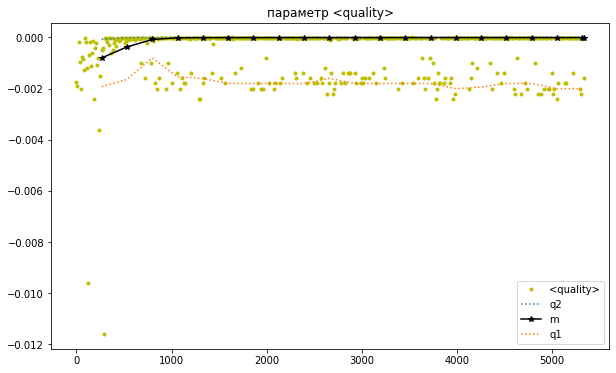

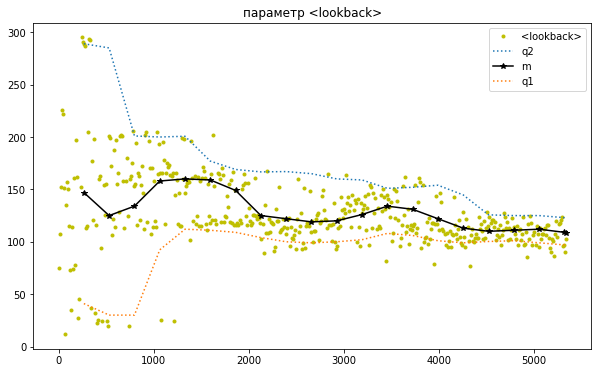

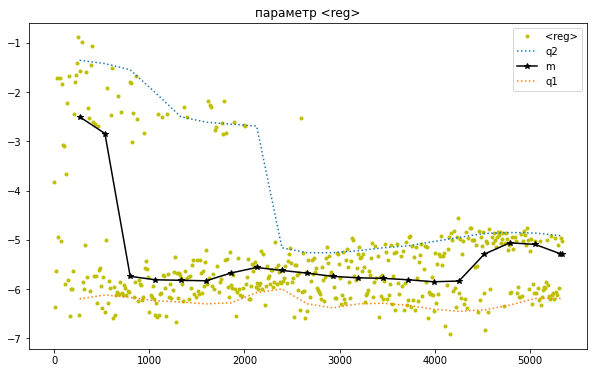

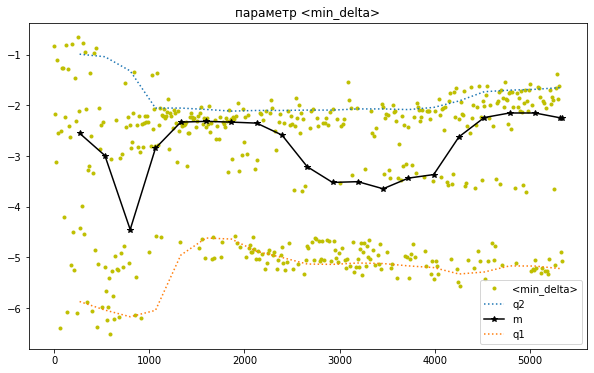

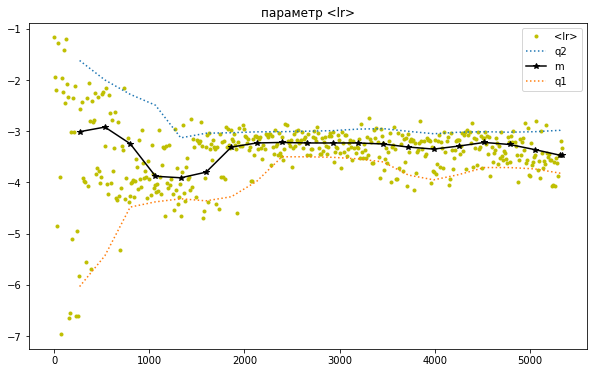

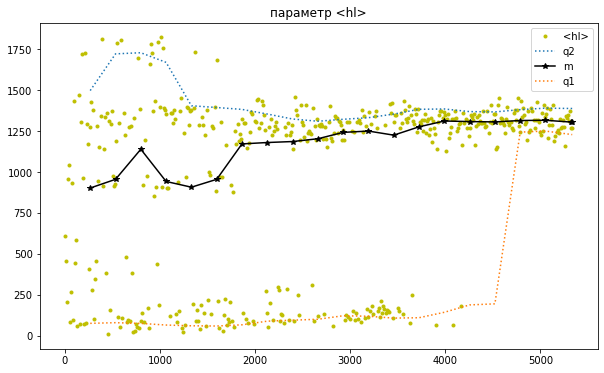

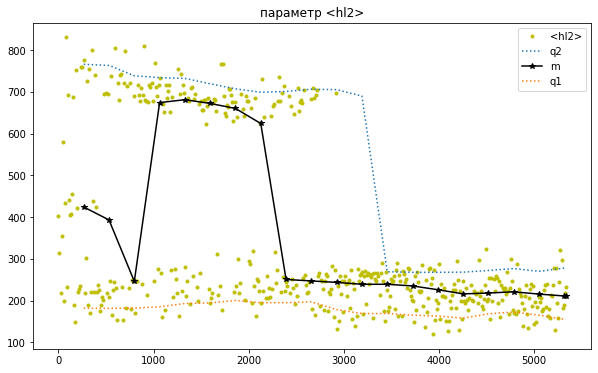

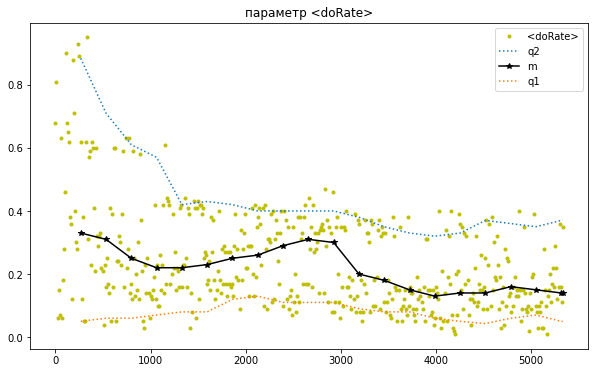

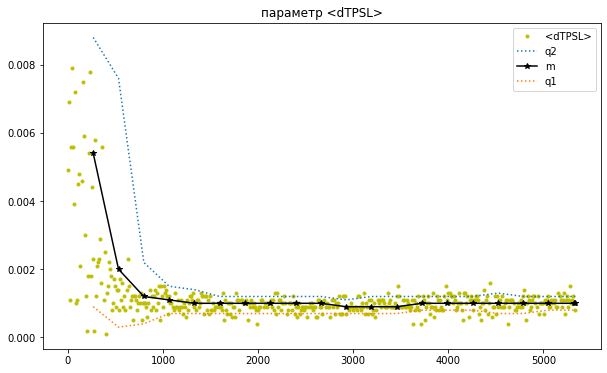

In [ ]:
modelGA.plot_hist_new(('quality','lookback','reg','min_delta','lr','hl','hl2','doRate','dTPSL'))

In [ ]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


1286 {'quality': 7.305194805194805e-07, 'lookback': 172, 'reg': -6.57, 'min_delta': -2.19, 'lr': -3.23, 'hl': 115, 'hl2': 669, 'doRate': 0.42, 'dTPSL': 0.0009}
1368 {'quality': 6.369426751592357e-07, 'lookback': 110, 'reg': -6.08, 'min_delta': -2.22, 'lr': -3.1, 'hl': 1220, 'hl2': 210, 'doRate': 0.14, 'dTPSL': 0.0008}
1376 {'quality': 8.785942492012779e-07, 'lookback': 120, 'reg': -2.31, 'min_delta': -2.52, 'lr': -4.17, 'hl': 1703, 'hl2': 194, 'doRate': 0.03, 'dTPSL': 0.0011}
2247 {'quality': 7.142857142857143e-07, 'lookback': 100, 'reg': -5.79, 'min_delta': -3.49, 'lr': -3.29, 'hl': 240, 'hl2': 689, 'doRate': 0.12, 'dTPSL': 0.0009}
2260 {'quality': 4.761904761904762e-07, 'lookback': 99, 'reg': -5.36, 'min_delta': -2.2, 'lr': -3.66, 'hl': 139, 'hl2': 225, 'doRate': 0.35, 'dTPSL': 0.0006}
2441 {'quality': 8.870967741935484e-07, 'lookback': 151, 'reg': -5.4, 'min_delta': -2.29, 'lr': -3.64, 'hl': 1204, 'hl2': 707, 'doRate': 0.35, 'dTPSL': 0.0011}
2496 {'quality': 9.554140127388535e-07, '

## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'dTPSL': 0.001,
 'doRate': 0.18,
 'hl': 1300,
 'hl2': 211,
 'lookback': 107,
 'lr': -3.47,
 'min_delta': -3.3,
 'reg': -5.59}

# Отчет по модели